In [2]:
import pickle
import time
import numpy as np
import torch
import torch.nn as nn
from torch import Tensor
from scipy.stats import wasserstein_distance
import matplotlib.pyplot as plt
lr = 0.001
batch_size = 4096
iterations = 20001
print_every = 2000 
hidden_dim = 512
load_checkpoint = 1999
# Model class
# Activation class
class Swish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: Tensor) -> Tensor: 
        return torch.sigmoid(x) * x
class MLP(nn.Module):
    def __init__(self, input_dim: int = 2, time_dim: int = 1, hidden_dim: int = 128):
        super().__init__()
        
        self.input_dim = input_dim
        self.time_dim = time_dim
        self.hidden_dim = hidden_dim

        self.main = nn.Sequential(
            nn.Linear(input_dim+time_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, hidden_dim),
            Swish(),
            nn.Linear(hidden_dim, input_dim),
            )
    

    def forward(self, x: Tensor, t: Tensor) -> Tensor:
        sz = x.size()
        x = x.reshape(-1, self.input_dim)
        t = t.reshape(-1, self.time_dim).float()

        t = t.reshape(-1, 1).expand(x.shape[0], 1)
        h = torch.cat([x, t], dim=1)
        output = self.main(h)
        
        return output.reshape(*sz)
if torch.cuda.is_available():
    device = 'cuda:0'
    print('Using gpu')
else:
    device = 'cpu'
    print('Using cpu.')
torch.manual_seed(42)


# reinit lora utils, loraGA
from tqdm import tqdm
from peft.tuners.lora import LoraLayer
@torch.no_grad()
def reinit_lora_modules(name, module, gamma, named_grad):
    r"""
    Reinitialize the lora model with the given configuration.
    """
    lora_r = 2


    # print("*************************")
    
    # grad_name = name + '.weight'
    grad_name = ".".join(name.split(".")[-2:]) + '.weight'
    # print(grad_name)
    grads = named_grad[grad_name]

    m, n = grads.shape
    # print(m,n)
    U, S, V = torch.linalg.svd(grads.float())
    B = U[:, lora_r : 2 * lora_r]
    A = V[:lora_r, :]
    m, n = grads.shape # m: feature_out, n: feature_in
    # the scale of output is only related to the feature_out
    
    B = B * m**0.25 / gamma**0.5
    A = A * m**0.25 / gamma**0.5

    module.lora_B.default.weight = torch.nn.Parameter(B.contiguous().cuda())
    module.lora_A.default.weight = torch.nn.Parameter(A.contiguous().cuda())
    return
def reinit_lora(model, gamma, named_grad):
    r"""
    Reinitialize the lora model with the given configuration.
    """
    inited_modules = []
    for name, module in tqdm(
        model.named_modules(),
        desc="Reinitializing Lora",
        total=len(list(model.named_modules())),
    ):
        
        if isinstance(module, LoraLayer):
            reinit_lora_modules(name, module, gamma, named_grad)

        pass
    return model



Using gpu


## Theorem 3.1

In [23]:
from peft import LoraConfig, get_peft_model
# checkpoint_steps = [1999,7999,13999,19999]
vf = MLP(input_dim=2, time_dim=1, hidden_dim=hidden_dim).to(device)
lora_config = LoraConfig(
    r=2,
    lora_alpha=16,
    target_modules=["main.0", "main.2", "main.4", "main.6", "main.8"],  # target Linear layers in MLP
    init_lora_weights="gaussian",
)
vf = get_peft_model(vf, lora_config)
print(vf.state_dict()['base_model.model.main.8.lora_A.default.weight'].shape)

gamma = 9
with open(f'/home/u5649209/workspace/flow_matching/ckpts/raw_model_gradients/models_grads_step19999.pkl', 'rb') as f:
    named_grad = pickle.load(f)
_ = reinit_lora(vf, gamma, named_grad)

# print(vf.state_dict().keys())
state_dict = vf.state_dict()
layer_num  = [0, 2, 4, 6, 8]
def w1distance(matrix1, matrix2):
    """
    Calculate the Wasserstein distance between two matrices.
    """
    # Flatten the matrices to 1D arrays
    flat_matrix1 = matrix1.flatten()
    flat_matrix2 = matrix2.flatten()
    
    # Calculate the Wasserstein distance
    distance = wasserstein_distance(flat_matrix1.cpu().numpy(), flat_matrix2.cpu().numpy())
    
    return distance

def fro_norm(matrix1, matrix2):
    """
    Calculate the Frobenius norm between two matrices.
    """
    # Flatten the matrices to 1D arrays
    flat_matrix1 = matrix1.flatten()
    flat_matrix2 = matrix2.flatten()
    
    flat_matrix1 = flat_matrix1.to(device)
    flat_matrix2 = flat_matrix2.to(device)
    # Calculate the Frobenius norm
    norm = torch.norm(flat_matrix1 - flat_matrix2, p='fro')
    
    return norm.item()

for i in range(5):
    ref_distance1 = []
    ref_distance2 = []
    loraB_weights = state_dict[f'base_model.model.main.{layer_num[i]}.lora_B.default.weight']
    loraA_weights = state_dict[f'base_model.model.main.{layer_num[i]}.lora_A.default.weight']

    raw_gradient = named_grad[f'main.{layer_num[i]}.weight']
    lora_combined_weights = loraB_weights @ loraA_weights
    distance1 = w1distance(lora_combined_weights, raw_gradient)
    distance2 = fro_norm(lora_combined_weights, raw_gradient)
    for j in range(100):
        random_loraB_weights = torch.randn_like(loraB_weights)
        random_loraA_weights = torch.randn_like(loraA_weights)
        random_combined_weights = random_loraB_weights @ random_loraA_weights
        random_distance1 = w1distance(random_combined_weights, raw_gradient)
        random_distance2 = fro_norm(random_combined_weights, raw_gradient)
        ref_distance1.append(random_distance1)
        ref_distance2.append(random_distance2)

    ref_distance1 = np.array(ref_distance1)
    ref_distance2 = np.array(ref_distance2)
    print(f"Layer {i}: Wasserstein Distance = {distance1}, Frobenius Norm = {distance2}")
    print(f"Layer {i}: Wasserstein Distance (random) = {ref_distance1.mean()}, Frobenius Norm (random) = {ref_distance2.mean()}")





torch.Size([2, 512])


Reinitializing Lora:   0%|          | 0/63 [00:00<?, ?it/s]

Reinitializing Lora: 100%|██████████| 63/63 [00:00<00:00, 690.84it/s]

*************************
main.0.weight
512 3
*************************
main.2.weight
512 512
*************************
main.4.weight
512 512
*************************
main.6.weight
512 512
*************************
main.8.weight
2 512
Layer 0: Wasserstein Distance = 0.01907008211638992, Frobenius Norm = 3.776705026626587
Layer 0: Wasserstein Distance (random) = 0.9677424334544464, Frobenius Norm (random) = 52.26941673278809


Layer 1: Wasserstein Distance = 0.0020985586214689518, Frobenius Norm = 3.7298574447631836
Layer 1: Wasserstein Distance (random) = 1.0014776251492354, Frobenius Norm (random) = 725.0692608642578
Layer 2: Wasserstein Distance = 0.0005639982756711808, Frobenius Norm = 6.871835231781006
Layer 2: Wasserstein Distance (random) = 1.0023242437707758, Frobenius Norm (random) = 726.3180511474609
Layer 3: Wasserstein Distance = 0.0010315818318468, Frobenius Norm = 10.338590621948242
Layer 3: Wasserstein Distance (random) = 1.0003940153763746, Frobenius Norm (random) = 725.5641809082031


RuntimeError: mat1 and mat2 shapes cannot be multiplied (2x0 and 2x512)

## Theorem 3.2

In [ ]:
# Missing

## Boss Ordered 1

0 step lora-ga weights & n steps Full-P Finetuned weight

torch.Size([2, 512])


Reinitializing Lora: 100%|██████████| 63/63 [00:00<00:00, 703.80it/s]

*************************
main.0.weight
512 3
*************************
main.2.weight
512 512
*************************
main.4.weight
512 512
*************************
main.6.weight
512 512
*************************
main.8.weight
2 512
Step: 1999, Module: main.0.weight, LR: 0.001, Distance: 80.88451385498047
Step: 1999, Module: main.2.weight, LR: 0.001, Distance: 90.36038208007812
Step: 1999, Module: main.4.weight, LR: 0.001, Distance: 90.011962890625
Step: 1999, Module: main.6.weight, LR: 0.001, Distance: 89.60514068603516
Step: 3999, Module: main.0.weight, LR: 0.001, Distance: 80.8271484375
Step: 3999, Module: main.2.weight, LR: 0.001, Distance: 90.39138793945312
Step: 3999, Module: main.4.weight, LR: 0.001, Distance: 90.07405090332031
Step: 3999, Module: main.6.weight, LR: 0.001, Distance: 89.64559936523438
Step: 5999, Module: main.0.weight, LR: 0.001, Distance: 80.7972640991211
Step: 5999, Module: main.2.weight, LR: 0.001, Distance: 90.36040496826172
Step: 5999, Module: main.4.weig

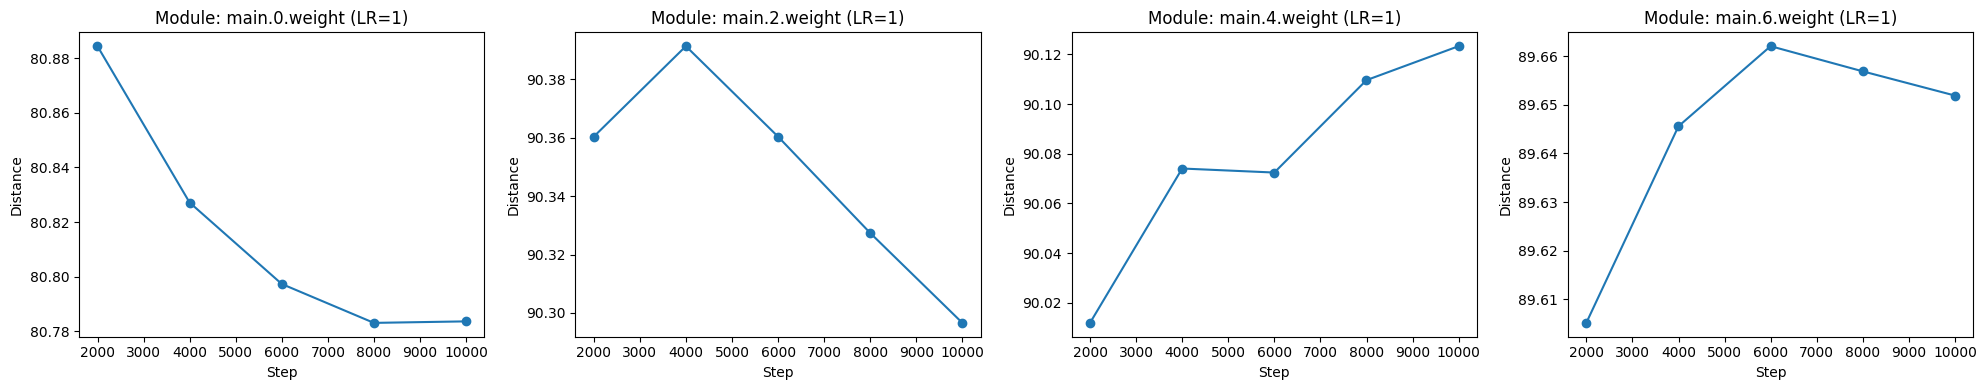

In [26]:
from peft import LoraConfig, get_peft_model
# checkpoint_steps = [1999,7999,13999,19999]
vf_lora_reinit = MLP(input_dim=2, time_dim=1, hidden_dim=hidden_dim).to(device)
lora_config = LoraConfig(
    r=2,
    lora_alpha=16,
    target_modules=["main.0", "main.2", "main.4", "main.6", "main.8"],  # target Linear layers in MLP
    init_lora_weights="gaussian",
)
vf_lora_reinit = get_peft_model(vf_lora_reinit, lora_config)
print(vf.state_dict()['base_model.model.main.8.lora_A.default.weight'].shape)

gamma = 9
with open(f'/home/u5649209/workspace/flow_matching/ckpts/raw_model_gradients/models_grads_step19999.pkl', 'rb') as f:
    named_grad = pickle.load(f)
_ = reinit_lora(vf_lora_reinit, gamma, named_grad)
state_dict = vf_lora_reinit.state_dict()


layer_num  = [0, 2, 4, 6]

# Select modules for comparison
module_list = ["main.0.weight", "main.0.bias", "main.2.weight", "main.2.bias",
                   "main.4.weight", "main.4.bias", "main.6.weight", "main.6.bias",
                #    "main.8.weight", "main.8.bias"
                ]
checkpoint_steps = [1999, 3999, 5999, 7999, 9999]


distance_module_dict = {}
# Calculate distance between original weights + lora_weights & trained weights
for ckpt in checkpoint_steps:

    weight_path = f'/home/u5649209/workspace/flow_matching/ckpts/weights/full_model_{ckpt}.pth'
    # Full model finetuned weights
    loaded_weights = torch.load(weight_path, map_location=device)
    
    learning_rate_list = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 20]
    
    for i in range(len(layer_num)):
        module = f'main.{layer_num[i]}.weight'
        if 'bias' in module:
            continue
        compared_weights = loaded_weights[module].to(device)

        loraB_weights = state_dict[f'base_model.model.main.{layer_num[i]}.lora_B.default.weight']
        loraA_weights = state_dict[f'base_model.model.main.{layer_num[i]}.lora_A.default.weight']

        lora_combined_weights = loraB_weights @ loraA_weights

        
        # distance = torch.norm(after_optimization_weights - weights).item()
        # distance = wasserstein_distance(after_optimization_weights.cpu().numpy().flatten(), weights.cpu().numpy().flatten())
        dot_product = np.dot(compared_weights.flatten().cpu().numpy(), lora_combined_weights.flatten().cpu().numpy())
        norm_after = np.linalg.norm(compared_weights.flatten().cpu().numpy())
        norm_weights = np.linalg.norm(lora_combined_weights.flatten().cpu().numpy())
        distance = np.arccos(np.clip(dot_product / (norm_after * norm_weights), -1.0, 1.0)) / np.pi * 180
        # Print the step, module, learning rate, and distance
        # print(f"Step: {step}, Module: {module}, LR: {lr}, Distance: {distance}")
        print(f"Step: {ckpt}, Module: {module}, LR: {lr}, Distance: {distance}")
        distance_module_dict[(ckpt, module, 1)] = distance

# Plot distance vs step for learning rate = 1
lr_fixed = 1
modules = [m for m in module_list if 'bias' not in m]
fig, axs = plt.subplots(1, len(modules), figsize=(5 * len(modules), 4))
if len(modules) == 1:
    axs = [axs]
for idx, module in enumerate(modules):
    steps = checkpoint_steps
    distances = [distance_module_dict[(step, module, lr_fixed)] for step in steps]
    axs[idx].plot(steps, distances, marker='o')
    axs[idx].set_xlabel("Step")
    axs[idx].set_ylabel("Distance")
    axs[idx].set_title(f"Module: {module} (LR={lr_fixed})")
print(distance_module_dict[(1999, 'main.0.weight', 1)])
plt.tight_layout()

plt.show()

## Boss Ordered 1 gamma variance

0 step lora-ga weights & n steps Full-P Finetuned weight

Reinitializing Lora: 100%|██████████| 63/63 [00:00<00:00, 862.52it/s]


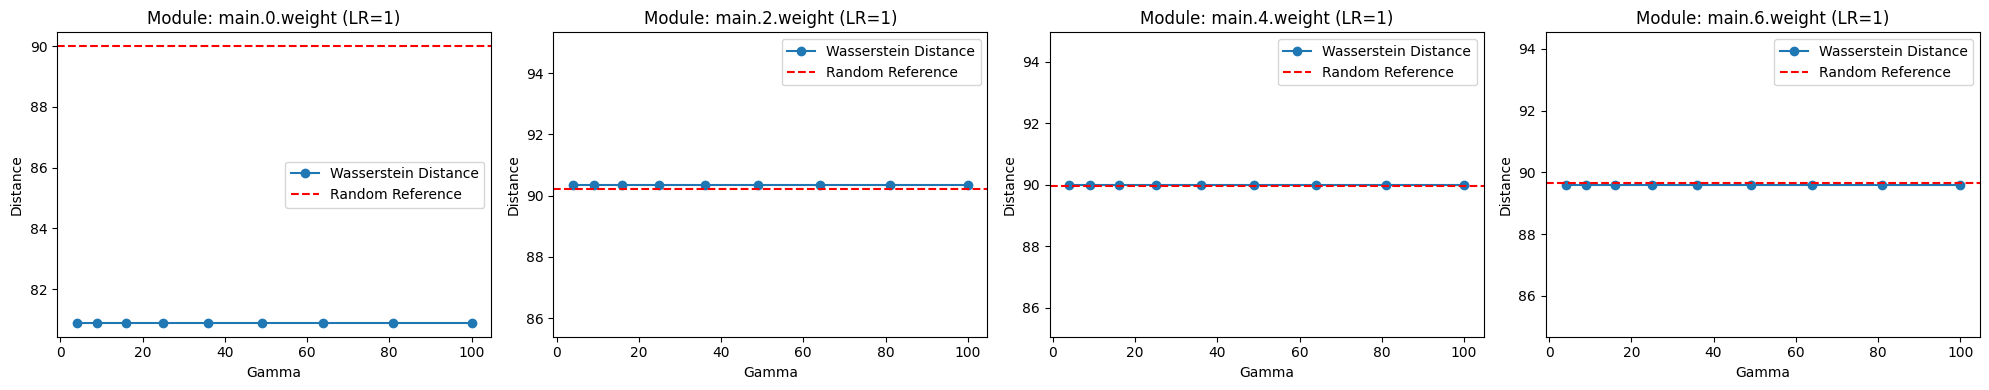

In [ ]:
from peft import LoraConfig, get_peft_model
# checkpoint_steps = [1999,7999,13999,19999]
gamma_list = [4, 9 , 16, 25, 36, 49, 64, 81, 100]
distance_module_dict = {}
for gamma in gamma_list:
    with open(f'/home/u5649209/workspace/flow_matching/ckpts/raw_model_gradients/models_grads_step19999.pkl', 'rb') as f:
        named_grad = pickle.load(f)
    vf_lora_reinit = MLP(input_dim=2, time_dim=1, hidden_dim=hidden_dim).to(device)
    lora_config = LoraConfig(
        r=2,
        lora_alpha=16,
        target_modules=["main.0", "main.2", "main.4", "main.6", "main.8"],  # target Linear layers in MLP
        init_lora_weights="gaussian",
    )
    vf_lora_reinit = get_peft_model(vf_lora_reinit, lora_config)
    _ = reinit_lora(vf_lora_reinit, gamma, named_grad)
    state_dict = vf_lora_reinit.state_dict()


    layer_num  = [0, 2, 4, 6]

    # Select modules for comparison
    module_list = ["main.0.weight", "main.0.bias", "main.2.weight", "main.2.bias",
                    "main.4.weight", "main.4.bias", "main.6.weight", "main.6.bias",
                    #    "main.8.weight", "main.8.bias"
                    ]
    checkpoint_steps = [1999, 3999, 5999, 7999, 9999]
    ckpt = 1999

    
    # Calculate distance between original weights + lora_weights & trained weights


    weight_path = f'/home/u5649209/workspace/flow_matching/ckpts/weights/full_model_{ckpt}.pth'
    # Full model finetuned weights
    loaded_weights = torch.load(weight_path, map_location=device)
    
    learning_rate_list = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 20]
    
    for i in range(len(layer_num)):
        module = f'main.{layer_num[i]}.weight'
        if 'bias' in module:
            continue
        compared_weights = loaded_weights[module].to(device)

        loraB_weights = state_dict[f'base_model.model.main.{layer_num[i]}.lora_B.default.weight']
        loraA_weights = state_dict[f'base_model.model.main.{layer_num[i]}.lora_A.default.weight']

        lora_combined_weights = loraB_weights @ loraA_weights

        
        # distance = torch.norm(after_optimization_weights - weights).item()

        distance = wasserstein_distance(compared_weights.cpu().numpy().flatten(), lora_combined_weights.cpu().numpy().flatten())
        dis_random = wasserstein_distance(compared_weights.cpu().numpy().flatten(), torch.randn_like(lora_combined_weights).cpu().numpy().flatten())

        # dot_product = np.dot(compared_weights.flatten().cpu().numpy(), lora_combined_weights.flatten().cpu().numpy())
        # norm_after = np.linalg.norm(compared_weights.flatten().cpu().numpy())
        # norm_weights = np.linalg.norm(lora_combined_weights.flatten().cpu().numpy())
        # distance = np.arccos(np.clip(dot_product / (norm_after * norm_weights), -1.0, 1.0)) / np.pi * 180

        # dot_product = np.dot(compared_weights.flatten().cpu().numpy(), lora_combined_weights.flatten().cpu().numpy())
        # norm_after = np.linalg.norm(compared_weights.flatten().cpu().numpy())
        # norm_weights = np.linalg.norm(lora_combined_weights.flatten().cpu().numpy())
        # distance = np.arccos(np.clip(dot_product / (norm_after * norm_weights), -1.0, 1.0)) / np.pi * 180


        # print(f"Gamma: {gamma}, Module: {module}, LR: {1}, Distance: {distance}")
        distance_module_dict[(gamma, module, 1)] = distance
        if (module, "random") not in distance_module_dict:
            distance_module_dict[(module, "random")] = dis_random

# Plot distance vs gamma for learning rate = 1
lr_fixed = 1
modules = [m for m in module_list if 'bias' not in m]
fig, axs = plt.subplots(1, len(modules), figsize=(5 * len(modules), 4))
if len(modules) == 1:
    axs = [axs]
for idx, module in enumerate(modules):
    gammas = gamma_list
    distances = [distance_module_dict[(gamma, module, lr_fixed)] for gamma in gammas]
    axs[idx].plot(gammas, distances, marker='o', label='Wasserstein Distance')
    # Plot a horizontal line for the single random reference value
    random_ref = distance_module_dict[(module, "random")]
    axs[idx].axhline(y=random_ref, linestyle='--', color='red', label='Random Reference')
    axs[idx].set_xlabel("Gamma")
    axs[idx].set_ylabel("Distance")
    axs[idx].set_title(f"Module: {module} (LR={lr_fixed})")
    axs[idx].legend()

plt.tight_layout()

plt.show()

## Boss Ordered 2

0 step lora-ga weights & n steps LoRA Finetuned weight

Reinitializing Lora: 100%|██████████| 63/63 [00:00<00:00, 791.76it/s]


/home/u5649209/workspace/flow_matching/ckpts/weights/lora_weights_2000
Step: 1999, Module: main.0.weight, LR: 0.001, Distance: 91.71571350097656
Step: 1999, Module: main.2.weight, LR: 0.001, Distance: 86.67738342285156
Step: 1999, Module: main.4.weight, LR: 0.001, Distance: 87.75481414794922
Step: 1999, Module: main.6.weight, LR: 0.001, Distance: 87.60629272460938
/home/u5649209/workspace/flow_matching/ckpts/weights/lora_weights_4000
Step: 3999, Module: main.0.weight, LR: 0.001, Distance: 92.81945037841797
Step: 3999, Module: main.2.weight, LR: 0.001, Distance: 87.75572204589844
Step: 3999, Module: main.4.weight, LR: 0.001, Distance: 88.08795166015625
Step: 3999, Module: main.6.weight, LR: 0.001, Distance: 88.50452423095703
/home/u5649209/workspace/flow_matching/ckpts/weights/lora_weights_6000
Step: 5999, Module: main.0.weight, LR: 0.001, Distance: 93.5718765258789
Step: 5999, Module: main.2.weight, LR: 0.001, Distance: 88.15121459960938
Step: 5999, Module: main.4.weight, LR: 0.001, Di

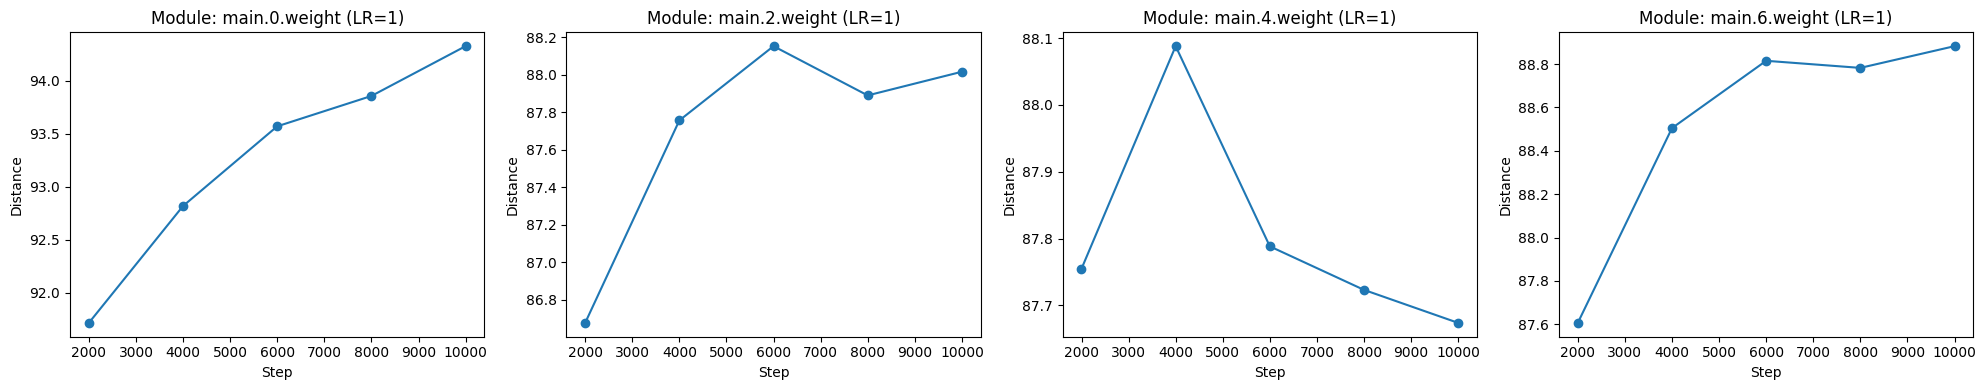

In [3]:
from peft import LoraConfig, get_peft_model, PeftModel, PeftConfig
# checkpoint_steps = [1999,7999,13999,19999]
vf_lora_reinit = MLP(input_dim=2, time_dim=1, hidden_dim=hidden_dim).to(device)
lora_config = LoraConfig(
    r=2,
    lora_alpha=4,
    target_modules=["main.0", "main.2", "main.4", "main.6", "main.8"],  # target Linear layers in MLP
    init_lora_weights="gaussian",
)
vf_lora_reinit = get_peft_model(vf_lora_reinit, lora_config)
# print(vf.state_dict()['base_model.model.main.8.lora_A.default.weight'].shape)

gamma = 9
gamma_list = [4, 9 , 16, 25, 36, 49, 64, 81, 100]
with open(f'/home/u5649209/workspace/flow_matching/ckpts/raw_model_gradients/models_grads_step19999.pkl', 'rb') as f:
    named_grad = pickle.load(f)
_ = reinit_lora(vf_lora_reinit, gamma, named_grad)
state_dict = vf_lora_reinit.state_dict()


layer_num  = [0, 2, 4, 6]

# Select modules for comparison
module_list = ["main.0.weight", "main.0.bias", "main.2.weight", "main.2.bias",
                   "main.4.weight", "main.4.bias", "main.6.weight", "main.6.bias",
                #    "main.8.weight", "main.8.bias"
                ]
checkpoint_steps = [1999, 3999, 5999, 7999, 9999]

distance_module_dict = {}
# Calculate distance between original weights + lora_weights & trained weights
for ckpt in checkpoint_steps:

    weight_path = f'/home/u5649209/workspace/flow_matching/ckpts/weights/lora_weights_{ckpt+1}'
    # Full model finetuned weights
    # peft_config = PeftConfig.from_pretrained(weight_path)
    vf_lora_compare = MLP(input_dim=2, time_dim=1, hidden_dim=hidden_dim).to(device)
    vf_lora_compare.load_state_dict(torch.load(f"/home/u5649209/workspace/flow_matching/ckpts/weights/full_model_9999.pth", map_location=device))
    vf_lora_compare = PeftModel.from_pretrained(vf_lora_compare, weight_path)
    
    print(weight_path)
    for i in range(4):
        module = f'main.{layer_num[i]}.weight'
        loraB_weights = state_dict[f'base_model.model.main.{layer_num[i]}.lora_B.default.weight']
        loraA_weights = state_dict[f'base_model.model.main.{layer_num[i]}.lora_A.default.weight']
        lora_combined_weights = loraB_weights @ loraA_weights

        # Load lora_combined weights for the compare model
        loraB_weights_compare = vf_lora_compare.state_dict()[f'base_model.model.main.{layer_num[i]}.lora_B.default.weight']
        loraA_weights_compare = vf_lora_compare.state_dict()[f'base_model.model.main.{layer_num[i]}.lora_A.default.weight']
        lora_combined_weights_compare = loraB_weights_compare @ loraA_weights_compare
        
        # distance = torch.norm(after_optimization_weights - weights).item()
        # distance = wasserstein_distance(after_optimization_weights.cpu().numpy().flatten(), weights.cpu().numpy().flatten())
        weight_1=loraB_weights
        weight_2=loraB_weights_compare
        
        dot_product = np.dot(weight_1.flatten().cpu().numpy(), weight_2.flatten().cpu().numpy())
        norm_after = np.linalg.norm(weight_1.flatten().cpu().numpy())
        norm_weights = np.linalg.norm(weight_2.flatten().cpu().numpy())
        distance = np.arccos(np.clip(dot_product / (norm_after * norm_weights), -1.0, 1.0)) / np.pi * 180
        # Print the step, module, learning rate, and distance
        # print(f"Step: {step}, Module: {module}, LR: {lr}, Distance: {distance}")
        print(f"Step: {ckpt}, Module: {module}, LR: {lr}, Distance: {distance}")
        distance_module_dict[(ckpt, module, 1)] = distance

# Plot distance vs step for learning rate = 1
lr_fixed = 1
modules = [m for m in module_list if 'bias' not in m]
fig, axs = plt.subplots(1, len(modules), figsize=(5 * len(modules), 4))
if len(modules) == 1:
    axs = [axs]
for idx, module in enumerate(modules):
    steps = checkpoint_steps
    distances = [distance_module_dict[(step, module, lr_fixed)] for step in steps]
    axs[idx].plot(steps, distances, marker='o')
    axs[idx].set_xlabel("Step")
    axs[idx].set_ylabel("Distance")
    axs[idx].set_title(f"Module: {module} (LR={lr_fixed})")
print(distance_module_dict[(1999, 'main.0.weight', 1)])
plt.tight_layout()
plt.savefig("distance_vs_step_lr1.png")
plt.show()

## Boss ordered 2, gamma value

Reinitializing Lora: 100%|██████████| 63/63 [00:00<00:00, 714.01it/s]


/home/u5649209/workspace/flow_matching/ckpts/weights/lora_weights_10000


Reinitializing Lora: 100%|██████████| 63/63 [00:00<00:00, 709.92it/s]


/home/u5649209/workspace/flow_matching/ckpts/weights/lora_weights_10000


Reinitializing Lora: 100%|██████████| 63/63 [00:00<00:00, 823.08it/s]


/home/u5649209/workspace/flow_matching/ckpts/weights/lora_weights_10000


Reinitializing Lora: 100%|██████████| 63/63 [00:00<00:00, 738.47it/s]


/home/u5649209/workspace/flow_matching/ckpts/weights/lora_weights_10000


Reinitializing Lora: 100%|██████████| 63/63 [00:00<00:00, 792.81it/s]


/home/u5649209/workspace/flow_matching/ckpts/weights/lora_weights_10000


Reinitializing Lora: 100%|██████████| 63/63 [00:00<00:00, 807.26it/s]


/home/u5649209/workspace/flow_matching/ckpts/weights/lora_weights_10000


Reinitializing Lora: 100%|██████████| 63/63 [00:00<00:00, 809.49it/s]


/home/u5649209/workspace/flow_matching/ckpts/weights/lora_weights_10000


Reinitializing Lora: 100%|██████████| 63/63 [00:00<00:00, 820.20it/s]


/home/u5649209/workspace/flow_matching/ckpts/weights/lora_weights_10000


Reinitializing Lora: 100%|██████████| 63/63 [00:00<00:00, 788.06it/s]


/home/u5649209/workspace/flow_matching/ckpts/weights/lora_weights_10000


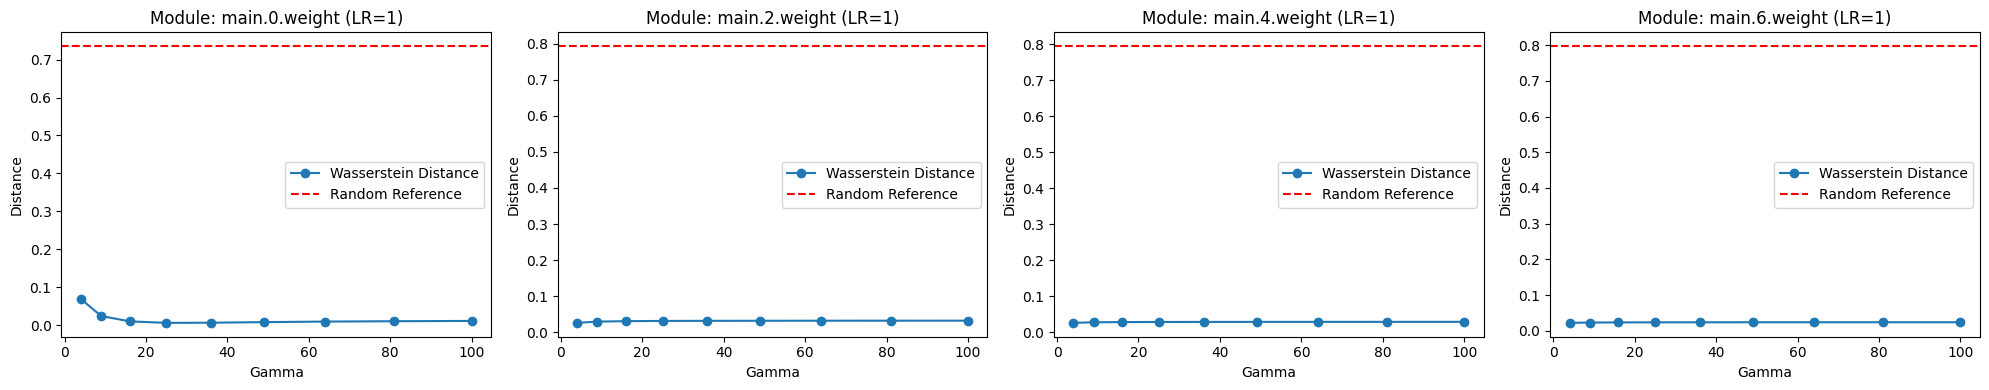

In [ ]:
from peft import LoraConfig, get_peft_model, PeftModel, PeftConfig
# checkpoint_steps = [1999,7999,13999,19999]

# print(vf.state_dict()['base_model.model.main.8.lora_A.default.weight'].shape)

gamma_list = [4, 9 , 16, 25, 36, 49, 64, 81, 100]
distance_module_dict = {}
for gamma in gamma_list:
    vf_lora_reinit = MLP(input_dim=2, time_dim=1, hidden_dim=hidden_dim).to(device)
    lora_config = LoraConfig(
        r=2,
        lora_alpha=16,
        target_modules=["main.0", "main.2", "main.4", "main.6", "main.8"],  # target Linear layers in MLP
        init_lora_weights="gaussian",
    )
    vf_lora_reinit = get_peft_model(vf_lora_reinit, lora_config)
    with open(f'/home/u5649209/workspace/flow_matching/ckpts/raw_model_gradients/models_grads_step19999.pkl', 'rb') as f:
        named_grad = pickle.load(f)
    _ = reinit_lora(vf_lora_reinit, gamma, named_grad)
    state_dict = vf_lora_reinit.state_dict()


    layer_num  = [0, 2, 4, 6]

    # Select modules for comparison
    module_list = ["main.0.weight", "main.0.bias", "main.2.weight", "main.2.bias",
                    "main.4.weight", "main.4.bias", "main.6.weight", "main.6.bias",
                    #    "main.8.weight", "main.8.bias"
                    ]
    checkpoint_steps = [1999, 3999, 5999, 7999, 9999]
    ckpt = 9999

    # Calculate distance between original weights + lora_weights & trained weights


    weight_path = f'/home/u5649209/workspace/flow_matching/ckpts/weights/lora_weights_{ckpt+1}'
    # Full model finetuned weights
    # peft_config = PeftConfig.from_pretrained(weight_path)
    vf_lora_compare = MLP(input_dim=2, time_dim=1, hidden_dim=hidden_dim).to(device)
    vf_lora_compare = PeftModel.from_pretrained(vf_lora_compare, weight_path)
    
    print(weight_path)
    for i in range(4):
        module = f'main.{layer_num[i]}.weight'
        loraB_weights = state_dict[f'base_model.model.main.{layer_num[i]}.lora_B.default.weight']
        loraA_weights = state_dict[f'base_model.model.main.{layer_num[i]}.lora_A.default.weight']
        lora_combined_weights = loraB_weights @ loraA_weights

        # Load lora_combined weights for the compare model
        loraB_weights_compare = vf_lora_compare.state_dict()[f'base_model.model.main.{layer_num[i]}.lora_B.default.weight']
        loraA_weights_compare = vf_lora_compare.state_dict()[f'base_model.model.main.{layer_num[i]}.lora_A.default.weight']
        lora_combined_weights_compare = loraB_weights_compare @ loraA_weights_compare
        
        # distance = torch.norm(after_optimization_weights - weights).item()
        
        weight_1=lora_combined_weights
        weight_2=lora_combined_weights_compare

        distance = wasserstein_distance(weight_1.cpu().numpy().flatten(), weight_2.cpu().numpy().flatten())
        # dot_product = np.dot(weight_1.flatten().cpu().numpy(), weight_2.flatten().cpu().numpy())
        # norm_after = np.linalg.norm(weight_1.flatten().cpu().numpy())
        # norm_weights = np.linalg.norm(weight_2.flatten().cpu().numpy())
        # distance = np.arccos(np.clip(dot_product / (norm_after * norm_weights), -1.0, 1.0)) / np.pi * 180
        # Print the step, module, learning rate, and distance
        # print(f"Step: {step}, Module: {module}, LR: {lr}, Distance: {distance}")
        distance_module_dict[(gamma, module, 1)] = distance
        if (module, "random") not in distance_module_dict:
            dis_random = wasserstein_distance(torch.randn_like(weight_2).cpu().numpy().flatten(), weight_1.cpu().numpy().flatten())
            distance_module_dict[(module, "random")] = dis_random
# Plot distance vs step for learning rate = 1
lr_fixed = 1
modules = [m for m in module_list if 'bias' not in m]
fig, axs = plt.subplots(1, len(modules), figsize=(5 * len(modules), 4))
if len(modules) == 1:
    axs = [axs]

for idx, module in enumerate(modules):
    gammas = gamma_list
    distances = [distance_module_dict[(gamma, module, lr_fixed)] for gamma in gammas]
    axs[idx].plot(gammas, distances, marker='o', label='Wasserstein Distance')
    # Plot a horizontal line for the single random reference value
    random_ref = distance_module_dict[(module, "random")]
    axs[idx].axhline(y=random_ref, linestyle='--', color='red', label='Random Reference')
    axs[idx].set_xlabel("Gamma")
    axs[idx].set_ylabel("Distance")
    axs[idx].set_title(f"Module: {module} (LR={lr_fixed})")
    axs[idx].legend()
plt.tight_layout()
plt.savefig("distance_vs_step_lr1.png")
plt.show()